In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 100
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.90)
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


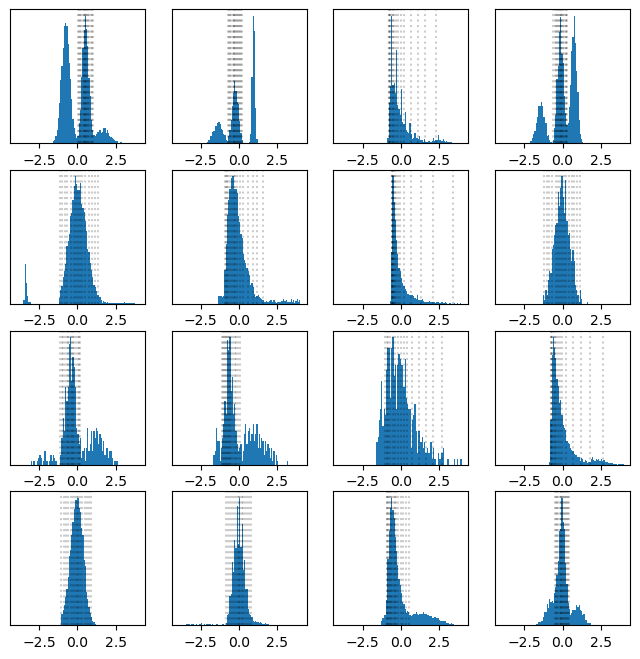

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

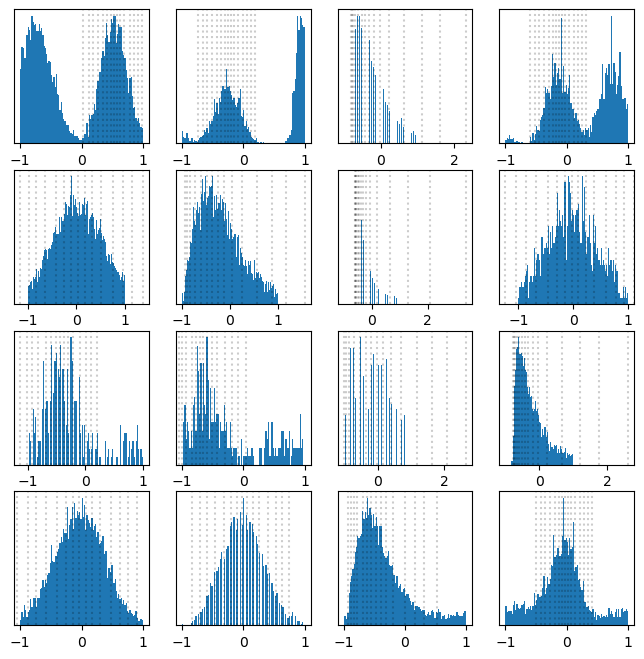

In [6]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
# idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-1, 1, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [7]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [8]:
def extract_features(data, range_max=4):

    features = np.histogram(data, np.linspace(-range_max, range_max, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [9]:
# extract features
x_train_1 = [extract_features(i) for i in x_train]
x_train_1 = np.array(x_train_1)
x_val_1 = [extract_features(i) for i in x_val]
x_val_1 = np.array(x_val_1)


In [10]:
x_train_2 = [extract_features(i, range_max=2) for i in x_train]
x_train_2 = np.array(x_train_2)
x_val_2 = [extract_features(i, range_max=2) for i in x_val]
x_val_2 = np.array(x_val_2)


In [11]:
x_train_1.shape

(5000, 100, 1)

In [12]:
x_train_2.shape

(5000, 100, 1)

In [13]:
y_train.shape


(5000, 16)

In [14]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [15]:
# define model

inputs_1 = tf.keras.layers.Input(shape=x_train_1.shape[1:])
inputs_2 = tf.keras.layers.Input(shape=x_train_2.shape[1:])

def conv_unit(inputs):
    x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    z = tf.keras.layers.Flatten()(x)
    return z

flatten_1 = conv_unit(inputs_1)
flatten_2 = conv_unit(inputs_2)

concatenated = tf.keras.layers.Concatenate()([flatten_1, flatten_2])

dense = tf.keras.layers.Dense(128, activation='relu')(concatenated)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(dense)
model = tf.keras.models.Model([inputs_1, inputs_2], o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 98, 32)               128       ['input_1[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 98, 32)               128       ['input_2[0][0]']             
                                                                                              

In [16]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    [x_train_1, x_train_2], 
    y_train,
    validation_data = ([x_val_1, x_val_2], y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/100


I0000 00:00:1716802134.450476   13661 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.29491, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.4049 - val_loss: 0.2949 - 8s/epoch - 13ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.29491 to 0.26971, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2844 - val_loss: 0.2697 - 4s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.26971 to 0.23380, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2591 - val_loss: 0.2338 - 4s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.23380
625/625 - 3s - loss: 0.2410 - val_loss: 0.2379 - 3s/epoch - 4ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.23380 to 0.20453, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.2247 - val_loss: 0.2045 - 4s/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.20453
625/625 - 3s - loss: 0.2096 - val_loss: 0.2060 - 3s/epoch - 4ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.20453 to 0.19060, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.2004 - val_loss: 0.1906 - 3s/epoch - 6ms/step
Epoch 8/100

Epoch 8: val_loss improved from 0.19060 to 0.18910, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1915 - val_loss: 0.1891 - 3s/epoch - 6ms/step
Epoch 9/100

Epoch 9: val_loss did not improve from 0.18910
625/625 - 3s - loss: 0.1843 - val_loss: 0.2001 - 3s/epoch - 4ms/step
Epoch 10/100

Epoch 10: val_loss improved from 0.18910 to 0.17047, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1790 - val_loss: 0.1705 - 4s/epoch - 7ms/step
Epoch 11/100

Epoch 11: val_loss did not improve from 0.17047
625/625 - 3s - loss: 0.1737 - val_loss: 0.1729 - 3s/epoch - 4ms/step
Epoch 12/100

Epoch 12: val_loss improved from 0.17047 to 0.16215, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1682 - val_loss: 0.1621 - 4s/epoch - 6ms/step
Epoch 13/100

Epoch 13: val_loss did not improve from 0.16215
625/625 - 3s - loss: 0.1607 - val_loss: 0.1669 - 3s/epoch - 4ms/step
Epoch 14/100

Epoch 14: val_loss did not improve from 0.16215
625/625 - 3s - loss: 0.1602 - val_loss: 0.1660 - 3s/epoch - 4ms/step
Epoch 15/100

Epoch 15: val_loss improved from 0.16215 to 0.15970, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1535 - val_loss: 0.1597 - 4s/epoch - 6ms/step
Epoch 16/100

Epoch 16: val_loss improved from 0.15970 to 0.15555, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1532 - val_loss: 0.1556 - 4s/epoch - 6ms/step
Epoch 17/100

Epoch 17: val_loss did not improve from 0.15555
625/625 - 3s - loss: 0.1496 - val_loss: 0.1588 - 3s/epoch - 4ms/step
Epoch 18/100

Epoch 18: val_loss improved from 0.15555 to 0.15179, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1451 - val_loss: 0.1518 - 4s/epoch - 6ms/step
Epoch 19/100

Epoch 19: val_loss did not improve from 0.15179
625/625 - 3s - loss: 0.1439 - val_loss: 0.1546 - 3s/epoch - 4ms/step
Epoch 20/100

Epoch 20: val_loss improved from 0.15179 to 0.15140, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1413 - val_loss: 0.1514 - 4s/epoch - 6ms/step
Epoch 21/100

Epoch 21: val_loss did not improve from 0.15140
625/625 - 3s - loss: 0.1398 - val_loss: 0.1558 - 3s/epoch - 4ms/step
Epoch 22/100

Epoch 22: val_loss did not improve from 0.15140
625/625 - 3s - loss: 0.1366 - val_loss: 0.1566 - 3s/epoch - 4ms/step
Epoch 23/100

Epoch 23: val_loss did not improve from 0.15140
625/625 - 3s - loss: 0.1344 - val_loss: 0.1615 - 3s/epoch - 4ms/step
Epoch 24/100

Epoch 24: val_loss improved from 0.15140 to 0.14739, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1336 - val_loss: 0.1474 - 4s/epoch - 6ms/step
Epoch 25/100

Epoch 25: val_loss did not improve from 0.14739
625/625 - 3s - loss: 0.1310 - val_loss: 0.1524 - 3s/epoch - 5ms/step
Epoch 26/100

Epoch 26: val_loss improved from 0.14739 to 0.14374, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1280 - val_loss: 0.1437 - 4s/epoch - 6ms/step
Epoch 27/100

Epoch 27: val_loss did not improve from 0.14374
625/625 - 3s - loss: 0.1250 - val_loss: 0.1447 - 3s/epoch - 4ms/step
Epoch 28/100

Epoch 28: val_loss did not improve from 0.14374
625/625 - 3s - loss: 0.1241 - val_loss: 0.1480 - 3s/epoch - 4ms/step
Epoch 29/100

Epoch 29: val_loss did not improve from 0.14374
625/625 - 3s - loss: 0.1246 - val_loss: 0.1440 - 3s/epoch - 5ms/step
Epoch 30/100

Epoch 30: val_loss did not improve from 0.14374
625/625 - 3s - loss: 0.1209 - val_loss: 0.1491 - 3s/epoch - 5ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.14374
625/625 - 3s - loss: 0.1190 - val_loss: 0.1458 - 3s/epoch - 4ms/step
Epoch 32/100

Epoch 32: val_loss improved from 0.14374 to 0.14085, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1181 - val_loss: 0.1409 - 3s/epoch - 6ms/step
Epoch 33/100

Epoch 33: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1175 - val_loss: 0.1454 - 3s/epoch - 4ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1150 - val_loss: 0.1541 - 3s/epoch - 4ms/step
Epoch 35/100

Epoch 35: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1136 - val_loss: 0.1456 - 3s/epoch - 4ms/step
Epoch 36/100

Epoch 36: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1120 - val_loss: 0.1429 - 3s/epoch - 4ms/step
Epoch 37/100

Epoch 37: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1120 - val_loss: 0.1471 - 3s/epoch - 4ms/step
Epoch 38/100

Epoch 38: val_loss did not improve from 0.14085
625/625 - 3s - loss: 0.1081 - val_loss: 0.1441 - 3s/epoch - 4ms/step
Epoch 39/100

Epoch 39: val_loss improved from 0.14085 to 0.13695, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1084 - val_loss: 0.1369 - 4s/epoch - 6ms/step
Epoch 40/100

Epoch 40: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1055 - val_loss: 0.1416 - 3s/epoch - 4ms/step
Epoch 41/100

Epoch 41: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1051 - val_loss: 0.1431 - 3s/epoch - 5ms/step
Epoch 42/100

Epoch 42: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1052 - val_loss: 0.1456 - 3s/epoch - 4ms/step
Epoch 43/100

Epoch 43: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1030 - val_loss: 0.1411 - 3s/epoch - 4ms/step
Epoch 44/100

Epoch 44: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1022 - val_loss: 0.1390 - 3s/epoch - 4ms/step
Epoch 45/100

Epoch 45: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1008 - val_loss: 0.1462 - 3s/epoch - 4ms/step
Epoch 46/100

Epoch 46: val_loss did not improve from 0.13695
625/625 - 3s - loss: 0.1000 - val_loss: 0.1386 - 3s/epoch - 6ms/step
Epoch 47/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 5s - loss: 0.0727 - val_loss: 0.1369 - 5s/epoch - 8ms/step
Epoch 79/100

Epoch 79: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0727 - val_loss: 0.1443 - 4s/epoch - 6ms/step
Epoch 80/100

Epoch 80: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0734 - val_loss: 0.1373 - 4s/epoch - 6ms/step
Epoch 81/100

Epoch 81: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0717 - val_loss: 0.1382 - 4s/epoch - 6ms/step
Epoch 82/100

Epoch 82: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0719 - val_loss: 0.1375 - 4s/epoch - 6ms/step
Epoch 83/100

Epoch 83: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0706 - val_loss: 0.1411 - 4s/epoch - 6ms/step
Epoch 84/100

Epoch 84: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0704 - val_loss: 0.1394 - 4s/epoch - 6ms/step
Epoch 85/100

Epoch 85: val_loss did not improve from 0.13687
625/625 - 4s - loss: 0.0698 - val_loss: 0.1372 - 4s/epoch - 6ms/step
Epoch 86/100



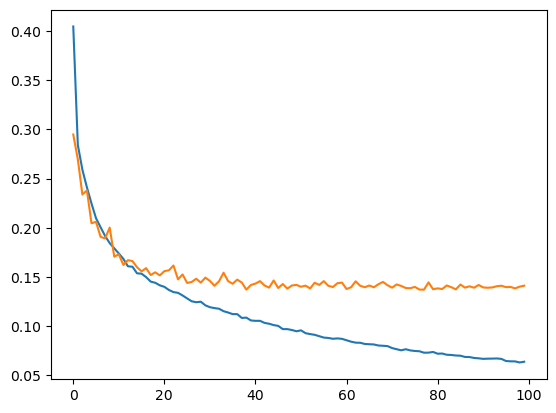

In [17]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [18]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
